In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
from scipy import stats
import geopandas as gpd
%matplotlib inline

## XYZ Data Wrangling

In [2]:
#LiveXYZ -- dataframe of XYZ survey data pulled from CSV
LiveXYZ = pd.read_csv('XYZ.csv')

C:\Users\aniha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#drop nan values from post code
LiveXYZ = LiveXYZ[LiveXYZ['post_code'].notna()]

#rename post code to ZIPCODE.....pull the first 5 chars for each value in zipcode column
LiveXYZ.rename(columns={"post_code": "ZIPCODE"})
LiveXYZ['ZIPCODE'] = LiveXYZ['post_code'].str[:5]

#drop the values that weren't 5 digits deep
LiveXYZ = LiveXYZ[LiveXYZ['ZIPCODE'].notna()]

#convert the zip code values to int so they can be filtered
LiveXYZ['ZIPCODE'] = LiveXYZ['ZIPCODE'].astype(int)

#filter for the NYC zip codes
LiveXYZ = LiveXYZ[(LiveXYZ['ZIPCODE'] >= 10001) & (LiveXYZ['ZIPCODE'] <= 11697)]

In [4]:
#XYZ_zip df is just the zip code / and primary categories 0 and 1
XYZ_zip = LiveXYZ[['ZIPCODE', 'primary_category.0_name','primary_category.1_name']]

In [5]:
pertinent_zips = [11102, 11103, 11105, 11106, 11101, 11104, 11109, 11120, 11206, 11211, 11249, 11207, 11221, 11237, 
                 10026, 10027, 10037, 10030, 10039, 10001, 10011, 10018, 10019, 10020, 10036, 10002, 10034, 10040,
                 10454, 10455, 10459, 10474, 11205, 11216, 11221, 11233, 11238, 11385, 11386, 10109, 11373,
                 11379, 11372, 11354, 11355, 11358, 11222]

XYZ_zip = XYZ_zip[XYZ_zip['ZIPCODE'].isin(pertinent_zips)]

In [6]:
#dictionary to map zips to neighborhoods
zip_dict ={ 11101:'Astoria/LIC', 11102:'Astoria/LIC', 11103:'Astoria/LIC', 11105:'Astoria/LIC', 11106:'Astoria/LIC', 11104:'LIC',
           11109:'LIC', 11120:'LIC', 11206:'Williamsburg/Bushwick/Bed-Stuy', 11211:'Williamsburg', 11249:'Williamsburg', 11207:'Bushwick',
           11221:'Bed-Stuy/Bushwick', 11237:'Bushwick', 10026:'Harlem', 10027:'Harlem', 10037:'Harlem', 10030:'Harlem', 10039:'Harlem',
           10001:'Chelsea', 10011:'Chelsea', 10018:'Chelsea', 10019:'Chelsea', 10020:'Chelsea', 10036:'Chelsea', 10002:'LES',
           10034: 'Inwood', 10040: 'Inwood', 10454: 'South Bronx', 10455: 'South Bronx', 10459: 'South Bronx', 10474: 'South Bronx', 
           11205: 'Bed-Stuy', 11216: 'Bed-Stuy', 11233: 'Bed-Stuy', 11238: 'Bed-Stuy',
           11385: 'Ridgewood', 11386: 'Ridgewood', 10109: 'Times Square', 
           11373: 'Elmhurst', 11379: 'Elmhurst', 11372: 'Jackson Heights', 
           11354: 'Flushing', 11355: 'Flushing', 11358: 'Flushing', 11222: 'Greenpoint'}

In [7]:
XYZ_zip['Neighborhood']= XYZ_zip['ZIPCODE'].map(zip_dict)

In [8]:
XYZ_zip.head()

ZIPCODE primary_category.0_name  primary_category.1_name Neighborhood
2     11373              Essentials  Groceries & Convenience     Elmhurst
7     10001          Arts & Culture              Art Gallery      Chelsea
9     10019                 Lodging  Hotels & Places To Stay      Chelsea
16    10001                    Food               Restaurant      Chelsea
18    10454                    Food               Restaurant  South Bronx

In [9]:
(XYZ_zip['primary_category.0_name'].unique())

array(['Essentials', 'Arts & Culture', 'Lodging', 'Food', 'Drinks',
       'Home & Hobby', 'Entertainment', 'Fitness', 'Groups',
       'Parks & Rec', 'Misc', 'Body', 'Services', 'Fashion'], dtype=object)

In [10]:
df1 = pd.crosstab(XYZ_zip['Neighborhood'], XYZ_zip['primary_category.0_name'].fillna(0))
df1 = df1.reset_index()
df1.head()

primary_category.0_name       Neighborhood  Arts & Culture  Body  Drinks  \
0                              Astoria/LIC              21     1     141   
1                                 Bed-Stuy              27     1      97   
2                        Bed-Stuy/Bushwick               9     0      17   
3                                 Bushwick               9     0      42   
4                                  Chelsea             210     1     408   

primary_category.0_name  Entertainment  Essentials  Fashion  Fitness  Food  \
0                                   17          38        0        1   617   
1                                    6          90        1        0   504   
2                                    2          24        1        1   115   
3                                    4          21        0        0   282   
4                                  159          34        3        0  1403   

primary_category.0_name  Groups  Home & Hobby  Lodging  Misc  Parks & Rec  \
0                            16             2       38     0            0   
1                            27             1        9     0            0   
2                             5             0        3     0            0   
3                             8             1        3     2            0   
4                            79             4      181     2            1   

primary_category.0_name  Services  
0                               1  
1                               0  
2                               0  
3                               0  
4                               0

In [11]:
# create a culture column (just the sum of all the cat0 columns)
df1['CULTURE'] =df1['Arts & Culture'] + df1['Body'] + df1['Drinks'] + df1['Entertainment'] + df1['Essentials'] + df1['Fashion'] + df1['Fitness'] + df1['Food'] + df1['Groups'] + df1['Home & Hobby'] + df1['Lodging'] + df1['Misc'] + df1['Parks & Rec'] + df1['Services']

## Zip Code Data Wrangling

In [12]:
zip_code=gpd.read_file("ZipsDissolve.shp")
#zip_code['ZIPCODE'] = zip_code['ZIPCODE'].astype(int)

In [13]:
zip_code.head()

Neighborho  \
0                     Astoria/LIC   
1                        Bed-Stuy   
2               Bed-Stuy/Bushwick   
3  Bed-Stuy/Bushwick/Williamsburg   
4                        Bushwick   

                                            geometry  
0  POLYGON ((1009325.441963157 227420.494683804, ...  
1  POLYGON ((997184.5413762229 194069.7142726228,...  
2  POLYGON ((1001383.64485465 188443.122179389, 1...  
3  POLYGON ((1002987.943483308 197218.0475428849,...  
4  POLYGON ((1005006.704865714 199410.7685511135,...

In [14]:
name_dict ={ 'Astoria/LIC':'Astoria/LIC', 'Bed-Stuy':'Bed-Stuy','Bed-Stuy/Bushwick':'Bed-Stuy/Bushwick',
            'Bed-Stuy/Bushwick/Williamsburg':'Williamsburg/Bushwick/Bed-Stuy','Bushwick':'Bushwick', 'Chelsea':'Chelsea',
            'Elmhurst':'Elmhurst', 'Flushing':'Flushing', 'Greenpoint':'Greenpoint', 'Harlem':'Harlem', 'Inwood':'Inwood',
            'Jackson Heights':'Jackson Heights','Lower East Side': 'LES','Long Island City':'LIC','Ridgewood':'Ridgewood',
            'South Bronx (Hunts Point and Mott Haven)':'South Bronx', 'Williamsburg':'Williamsburg'}

In [15]:
zip_code['Neighborhood']= zip_code['Neighborho'].map(name_dict)

In [16]:
borders = gpd.read_file("boro_new.shp")

In [17]:
borders.head()

OBJECTID  boro_code      boro_name     shape_leng     Shape_Le_1  \
0         1        2.0          Bronx  462958.187578  462947.403873   
1         2        5.0  Staten Island  325956.009000  325947.003862   
2         3        3.0       Brooklyn  738745.842115  738731.571583   
3         4        4.0         Queens  904188.424488  904160.756624   
4         5        1.0      Manhattan  361212.476098  361210.062528   

     Shape_Area                                           geometry  
0  1.186614e+09  (POLYGON ((1012821.80570522 229228.2646902204,...  
1  1.623759e+09  (POLYGON ((970217.0224766433 145643.3321228921...  
2  1.937593e+09  (POLYGON ((1021176.478956476 151374.7970378995...  
3  3.045879e+09  (POLYGON ((1029606.076598555 156073.8142146468...  
4  6.366023e+08  (POLYGON ((981219.0559187233 188655.3156525642...

## Pure Volume

In [18]:
XYZ_map = zip_code.merge(df1, on='Neighborhood')

C:\Users\aniha\Anaconda3\lib\site-packages\geopandas\plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
C:\Users\aniha\Anaconda3\lib\site-packages\geopandas\plotting.py:253: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


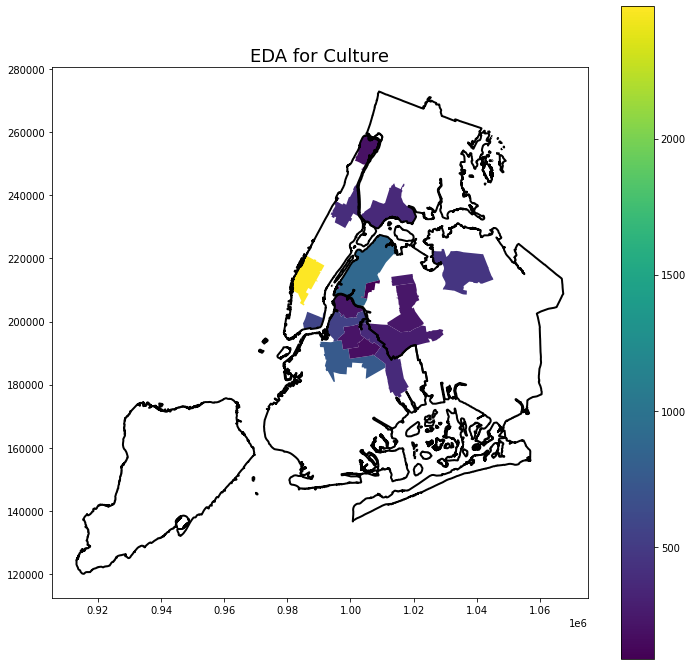

In [19]:
f, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal')
ax.set_title("EDA for Culture", fontsize=18)
XYZ_map.plot(axes=ax, column='CULTURE', legend = True, cmap='viridis')
borders.boundary.plot(axes=ax, color=None,edgecolor='k',linewidth = 2)

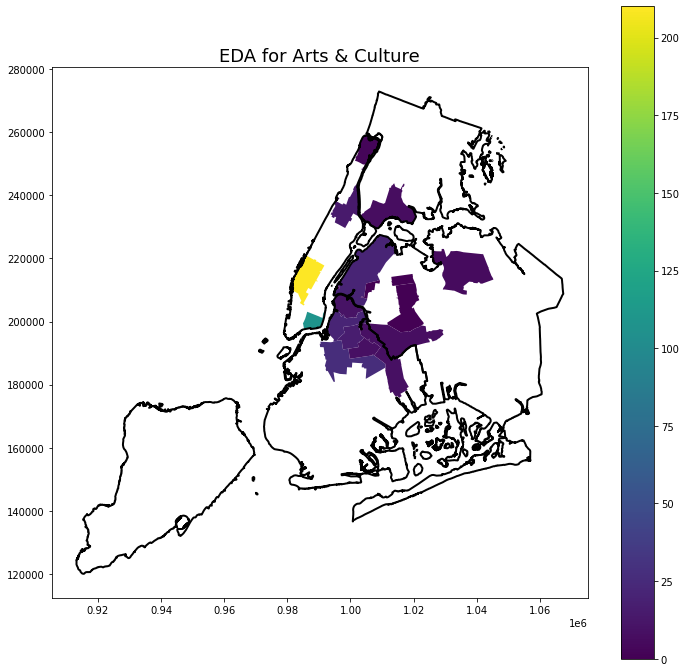

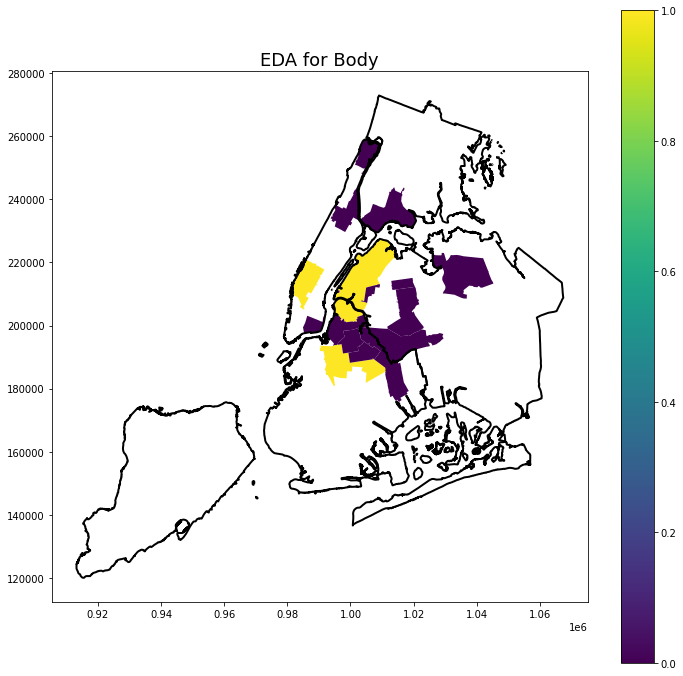

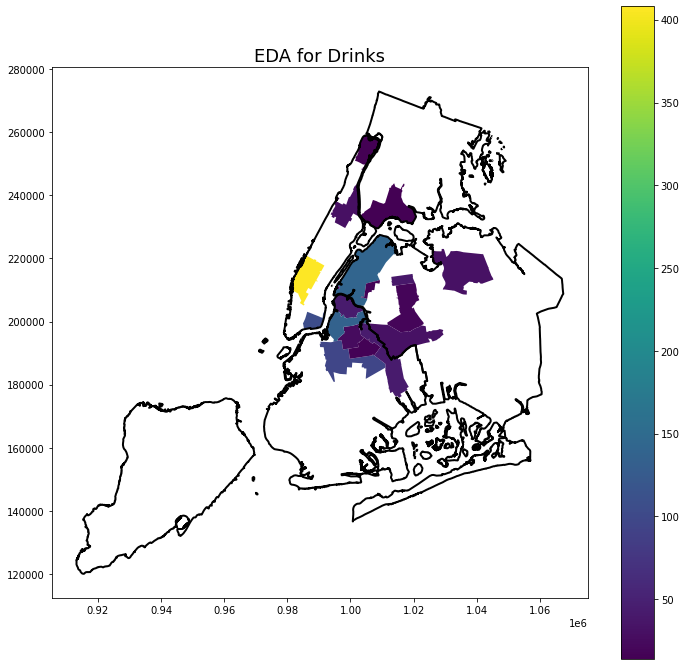

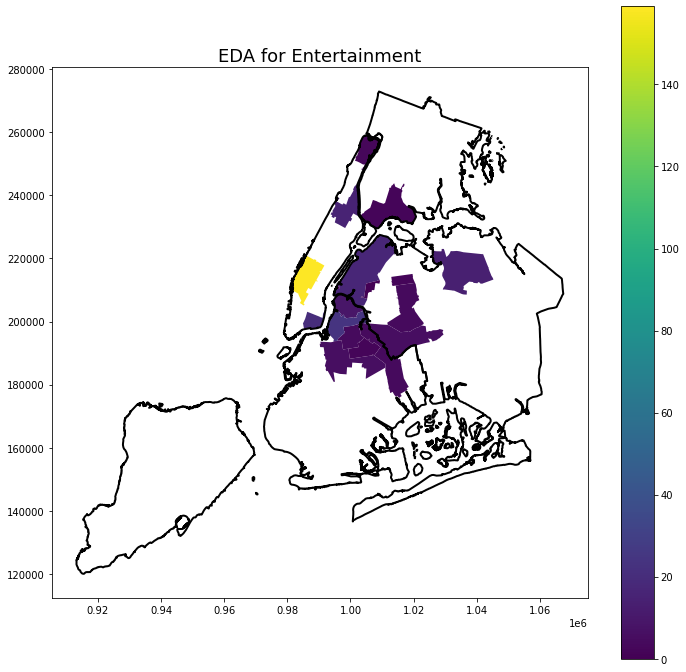

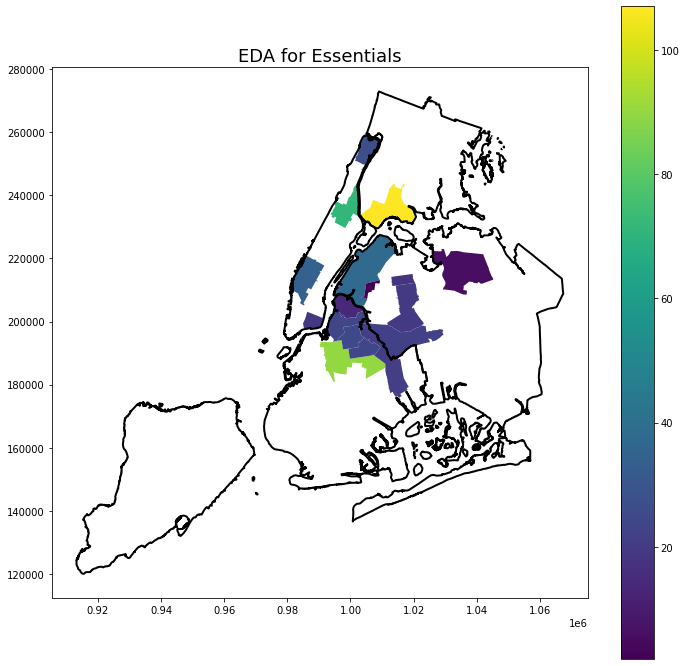

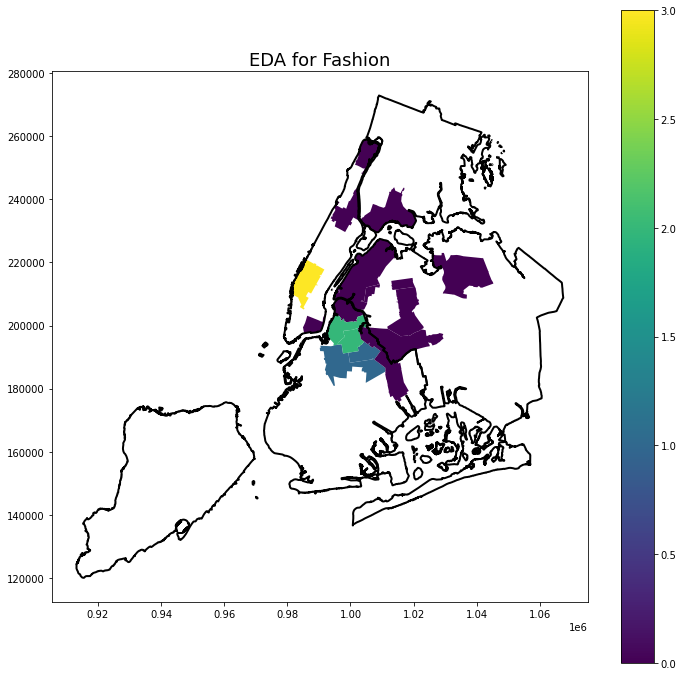

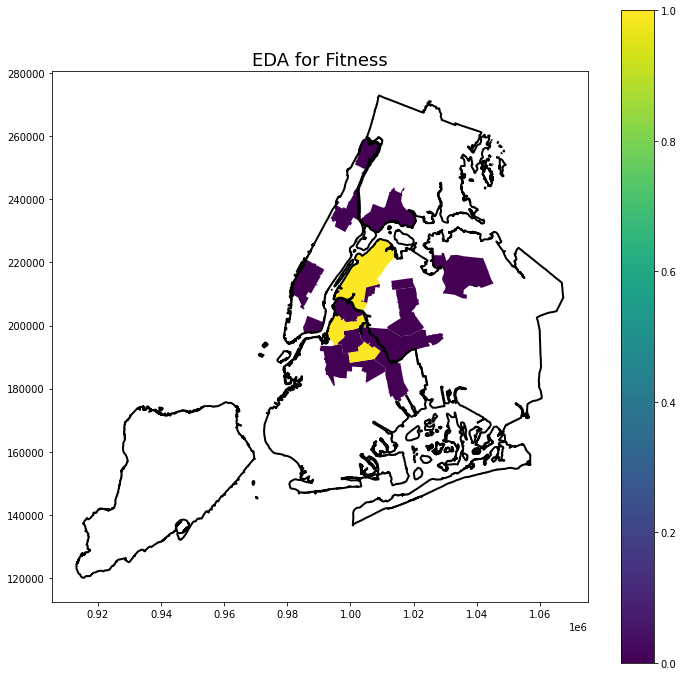

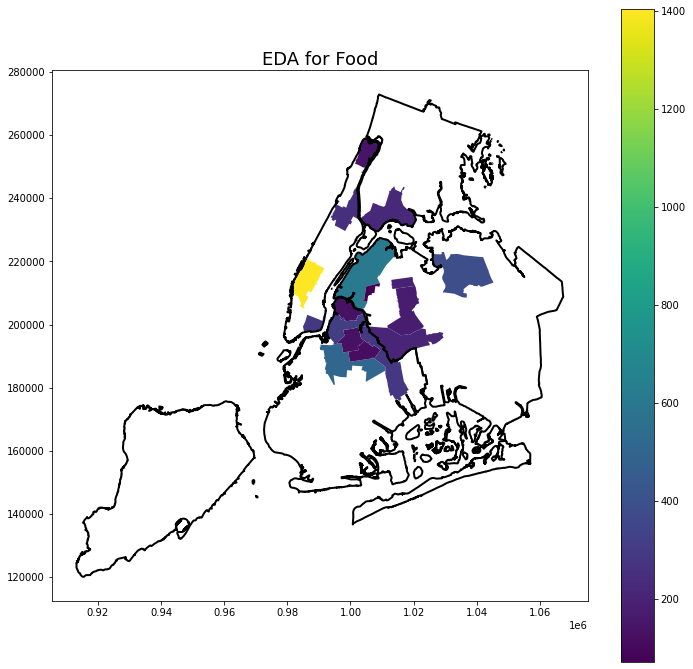

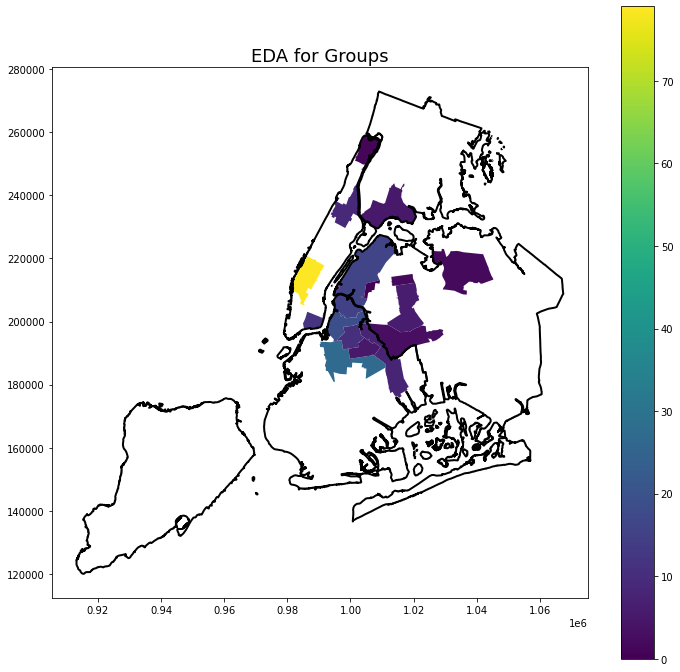

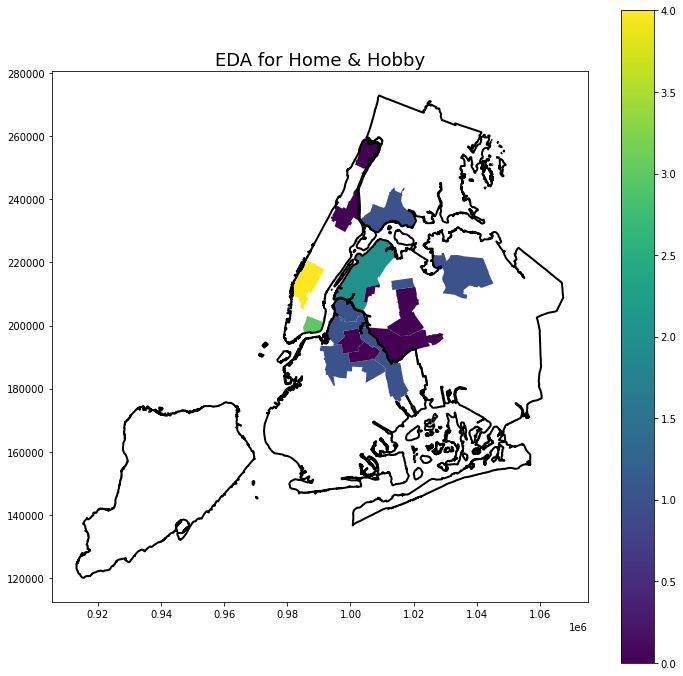

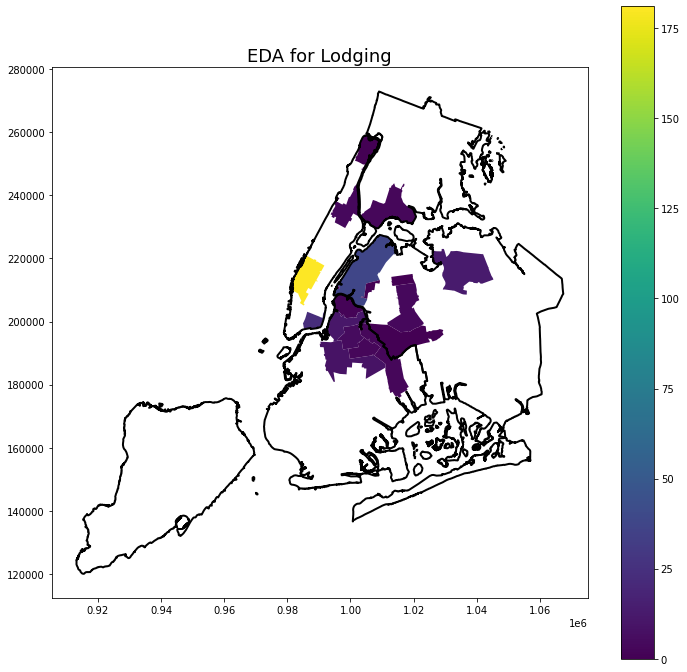

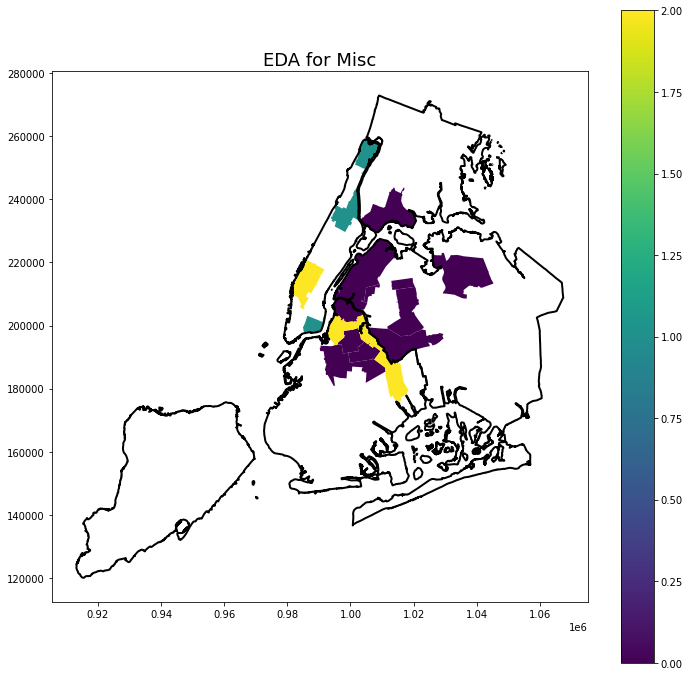

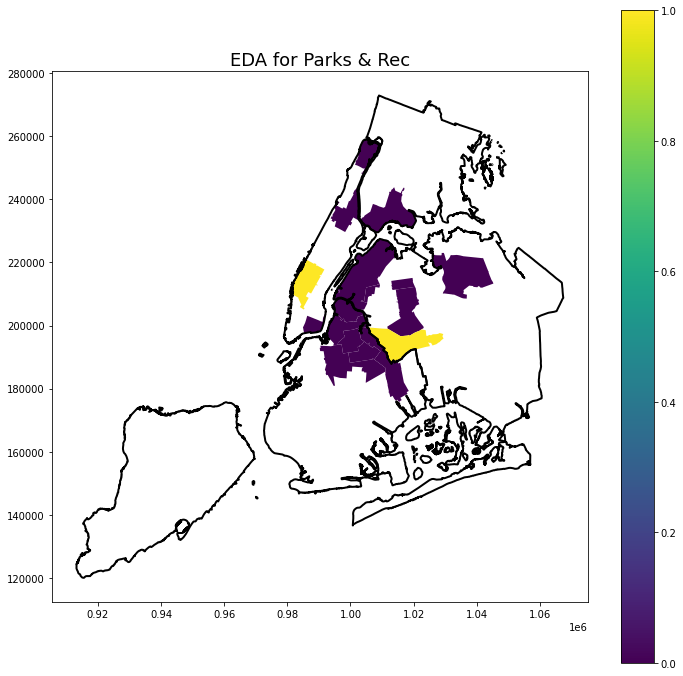

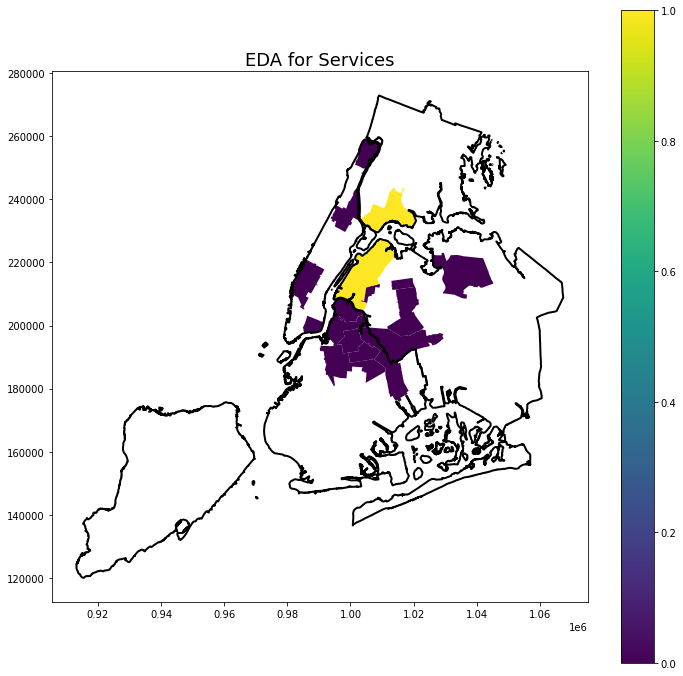

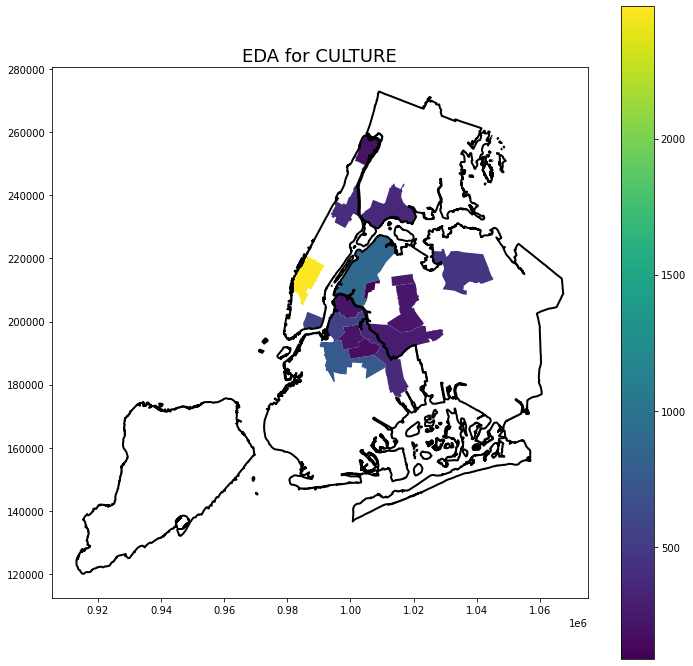

In [20]:
culture_list = ['Arts & Culture', 'Body',
       'Drinks', 'Entertainment', 'Essentials', 'Fashion', 'Fitness', 'Food',
       'Groups', 'Home & Hobby', 'Lodging', 'Misc', 'Parks & Rec', 'Services',
       'CULTURE']
for x in culture_list:
    f, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect('equal')
    ax.set_title("EDA for {}".format(x), fontsize=18)
    XYZ_map.plot(axes=ax, column=x, legend = True, cmap='viridis')
    borders.boundary.plot(axes=ax, color=None,edgecolor='k',linewidth = 2)

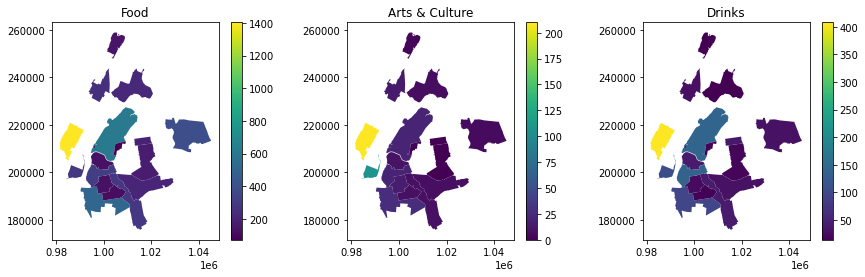

In [21]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
ax1 = XYZ_map.plot(ax=ax1, column = 'Food', legend=True).title.set_text('Food')
ax2 = XYZ_map.plot(ax=ax2, column = 'Arts & Culture', legend=True).title.set_text('Arts & Culture')
ax3 = XYZ_map.plot(ax=ax3, column = 'Drinks', legend=True).title.set_text('Drinks')
#ax4 = UniqueZip.plot(ax=ax4, column = 'Entertainment', legend=True).title.set_text('Entertainment')

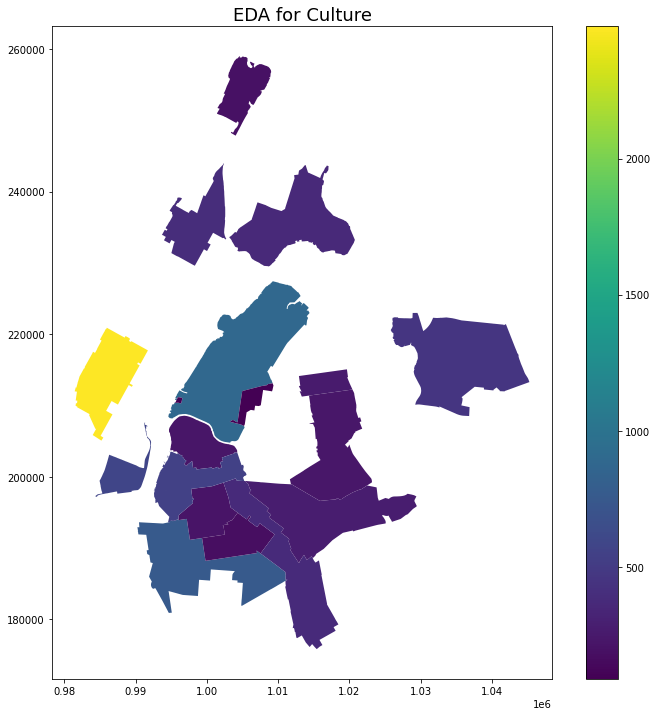

In [22]:
f, ax = plt.subplots(1, figsize=(12, 12))
ax.set_title("EDA for Culture", fontsize=18)
XYZ_map.plot(axes=ax, column='CULTURE', legend = True, cmap='viridis')

In [23]:
y = XYZ_map.sort_values("CULTURE", ascending=False)

In [24]:
y.head()

Neighborho                                           geometry  \
5           Chelsea  POLYGON ((986161.7127001534 220802.607657128, ...   
0       Astoria/LIC  POLYGON ((1009325.441963157 227420.494683804, ...   
1          Bed-Stuy  POLYGON ((997184.5413762229 194069.7142726228,...   
13  Lower East Side  POLYGON ((991339.8703228086 207576.7837151289,...   
16     Williamsburg  POLYGON ((994923.6039689785 203481.6144120427,...   

    Neighborhood  Arts & Culture  Body  Drinks  Entertainment  Essentials  \
5        Chelsea             210     1     408            159          34   
0    Astoria/LIC              21     1     141             17          38   
1       Bed-Stuy              27     1      97              6          90   
13           LES             109     0     106             20          19   
16  Williamsburg              21     0     136             24          24   

    Fashion  Fitness  Food  Groups  Home & Hobby  Lodging  Misc  Parks & Rec  \
5         3        0  1403      79             4      181     2            1   
0         0        1   617      16             2       38     0            0   
1         1        0   504      27             1        9     0            0   
13        0        0   290      12             3       23     1            0   
16        2        1   311      19             1       11     2            0   

    Services  CULTURE  
5          0     2485  
0          1      893  
1          0      763  
13         0      583  
16         0      552

## Percentage

In [25]:
culture_features = ['Arts & Culture', 'Body', 'Drinks', 'Entertainment', 'Essentials', 'Fashion', 'Fitness',
                    'Food', 'Groups', 'Home & Hobby', 'Lodging', 'Misc', 'Parks & Rec', 'Services',]


df2 = df1.copy()

In [26]:
df2[culture_features] = df2[culture_features].div(df2[culture_features].sum(axis=1), axis=0)

df2.head()

primary_category.0_name       Neighborhood  Arts & Culture      Body  \
0                              Astoria/LIC        0.023516  0.001120   
1                                 Bed-Stuy        0.035387  0.001311   
2                        Bed-Stuy/Bushwick        0.050847  0.000000   
3                                 Bushwick        0.024194  0.000000   
4                                  Chelsea        0.084507  0.000402   

primary_category.0_name    Drinks  Entertainment  Essentials   Fashion  \
0                        0.157895       0.019037    0.042553  0.000000   
1                        0.127130       0.007864    0.117955  0.001311   
2                        0.096045       0.011299    0.135593  0.005650   
3                        0.112903       0.010753    0.056452  0.000000   
4                        0.164185       0.063984    0.013682  0.001207   

primary_category.0_name  Fitness      Food    Groups  Home & Hobby   Lodging  \
0                        0.00112  0.690929  0.017917      0.002240  0.042553   
1                        0.00000  0.660550  0.035387      0.001311  0.011796   
2                        0.00565  0.649718  0.028249      0.000000  0.016949   
3                        0.00000  0.758065  0.021505      0.002688  0.008065   
4                        0.00000  0.564588  0.031791      0.001610  0.072837   

primary_category.0_name      Misc  Parks & Rec  Services  CULTURE  
0                        0.000000     0.000000   0.00112      893  
1                        0.000000     0.000000   0.00000      763  
2                        0.000000     0.000000   0.00000      177  
3                        0.005376     0.000000   0.00000      372  
4                        0.000805     0.000402   0.00000     2485

In [27]:
Percentage_Map = zip_code.merge(df2, on='Neighborhood')

C:\Users\aniha\Anaconda3\lib\site-packages\geopandas\plotting.py:389: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)
C:\Users\aniha\Anaconda3\lib\site-packages\geopandas\plotting.py:253: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


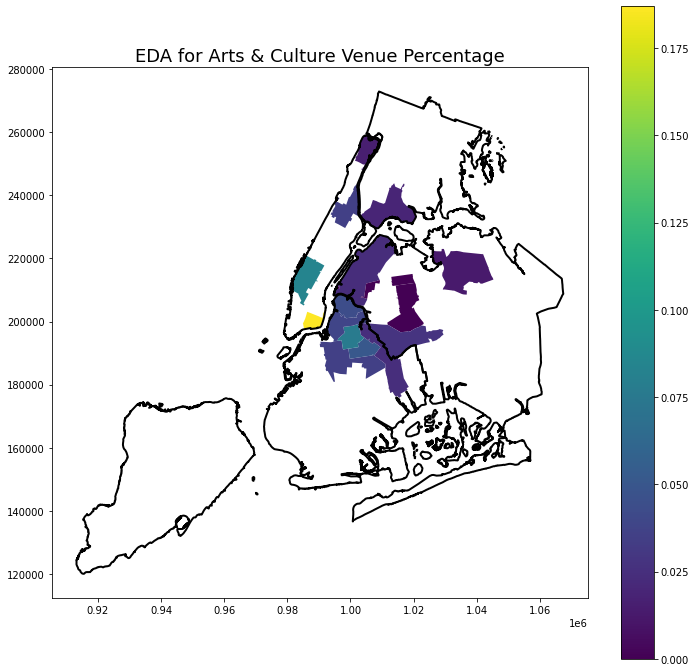

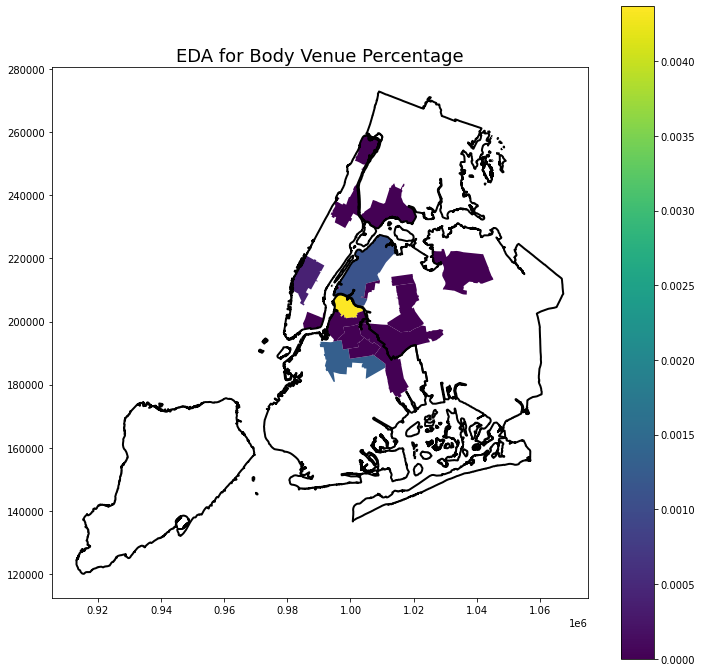

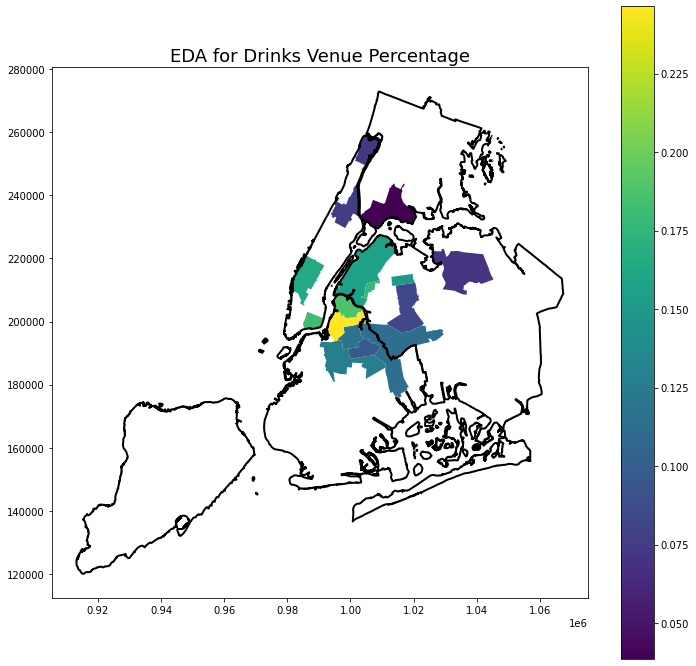

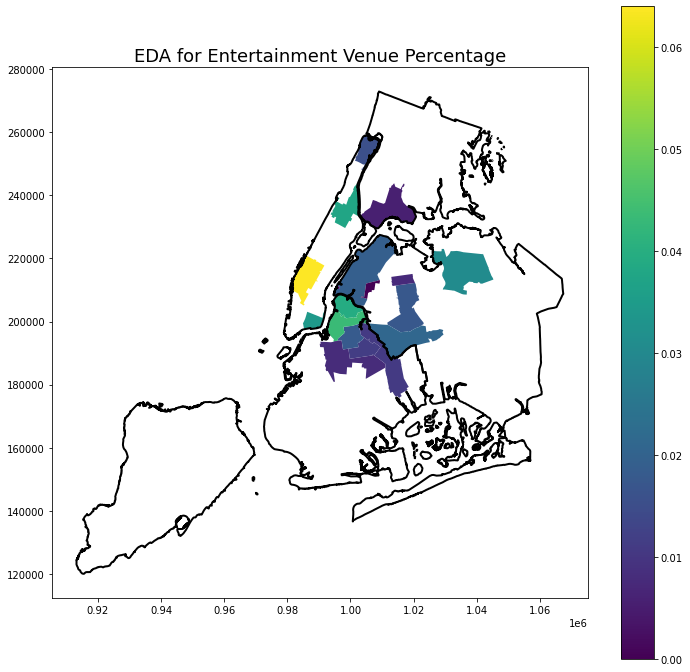

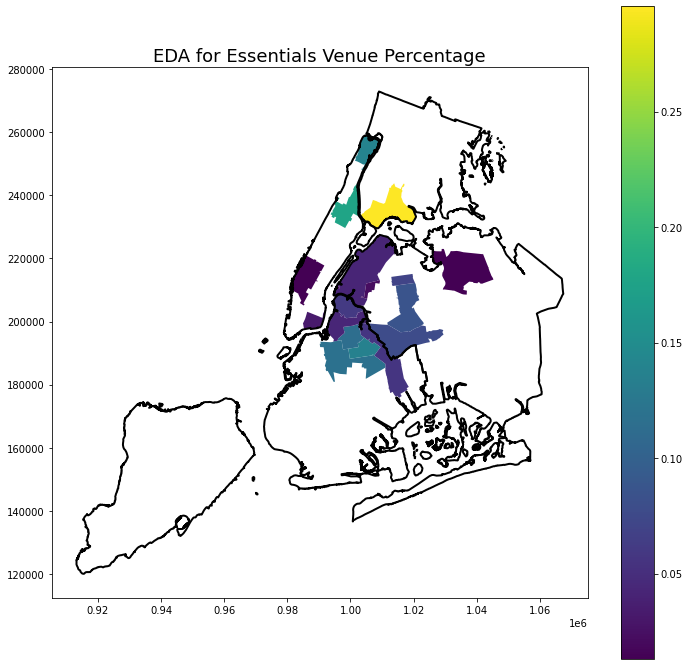

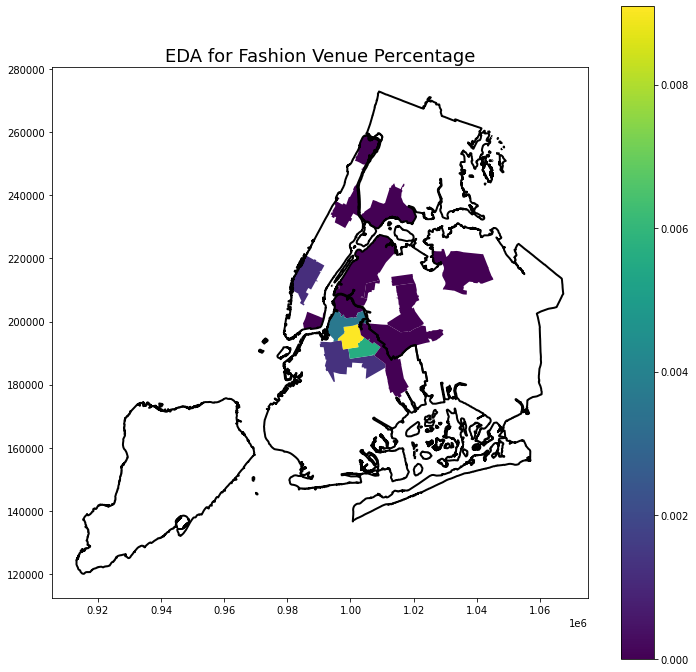

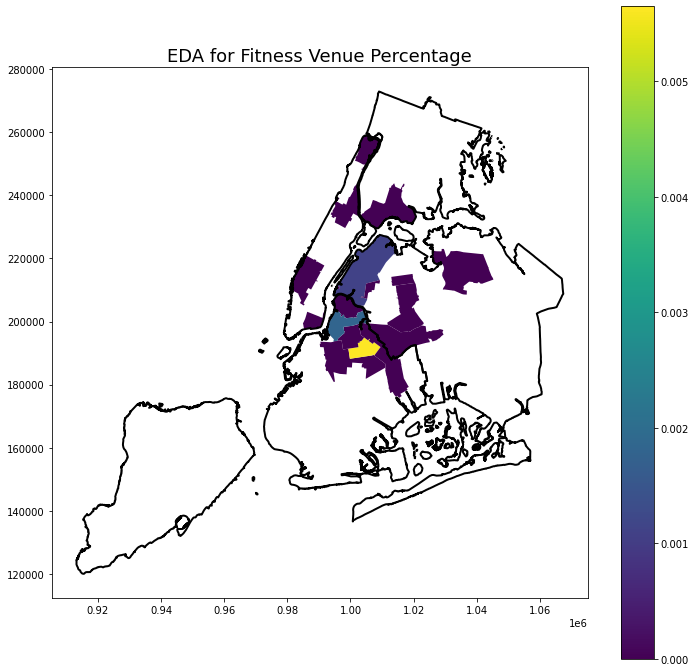

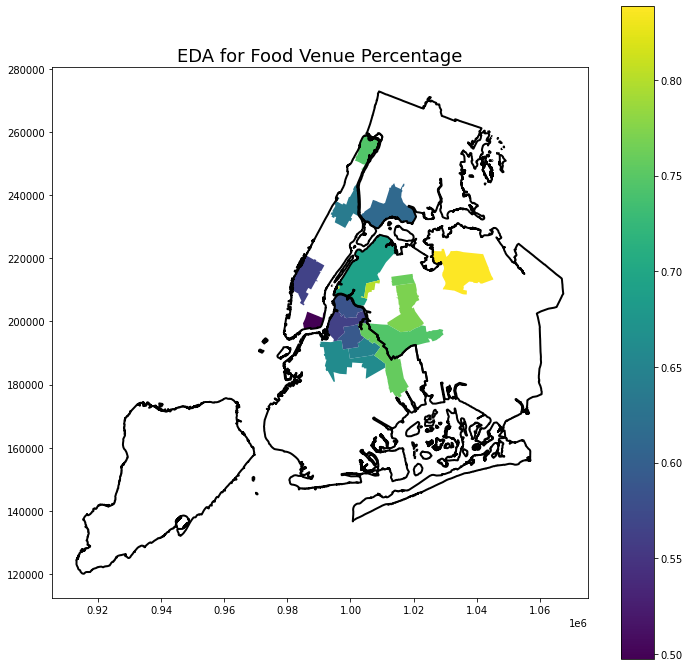

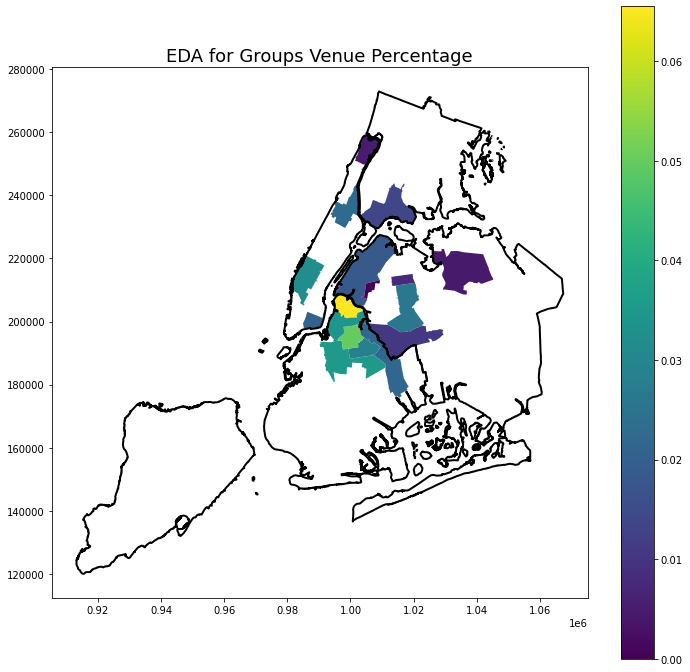

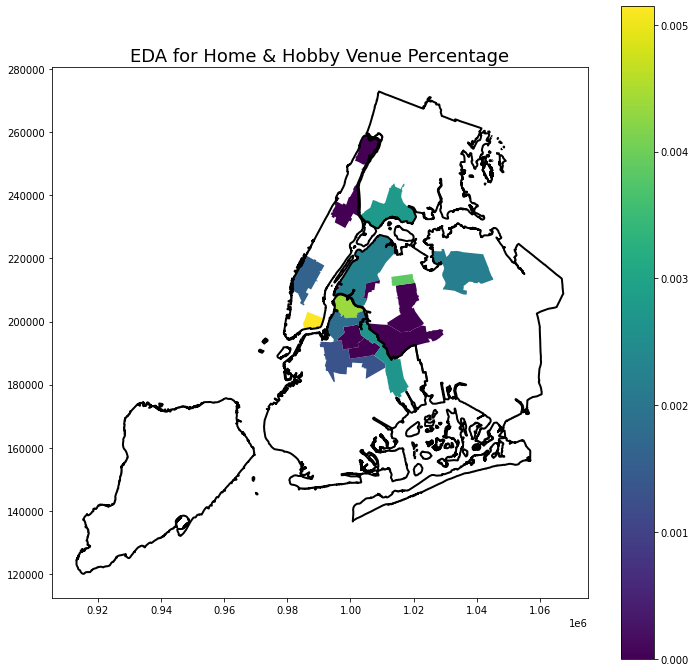

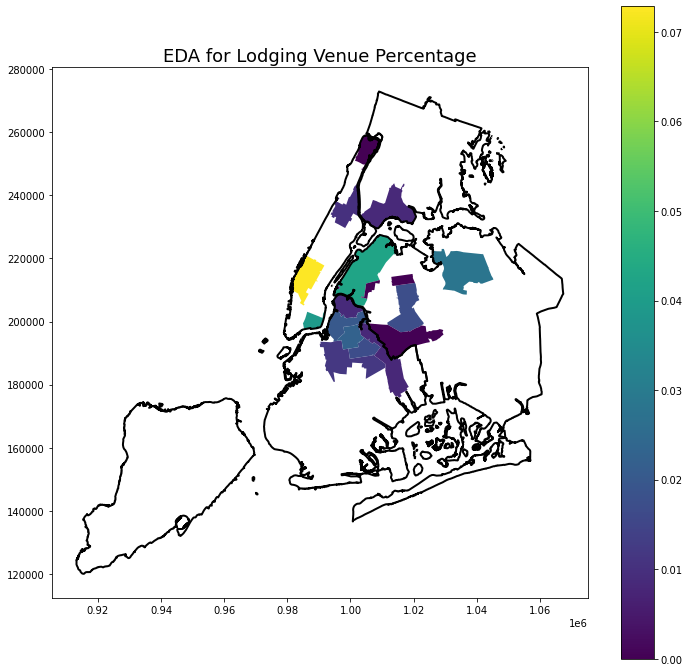

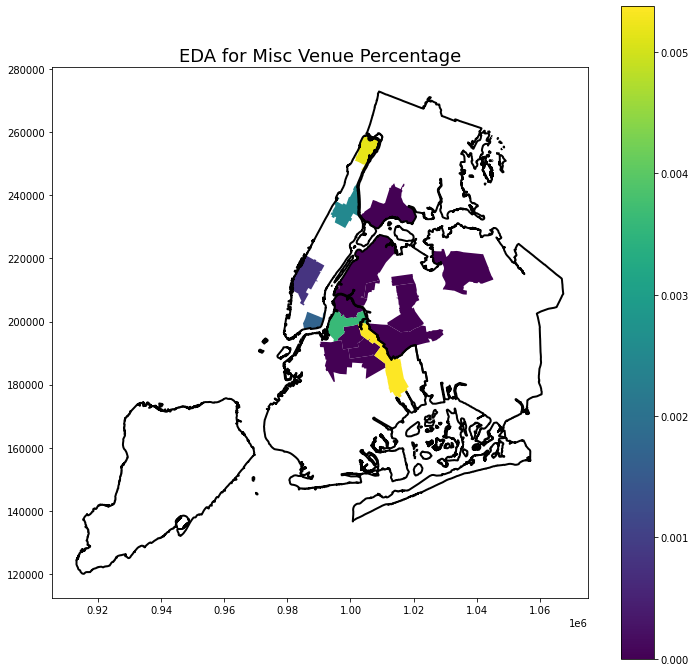

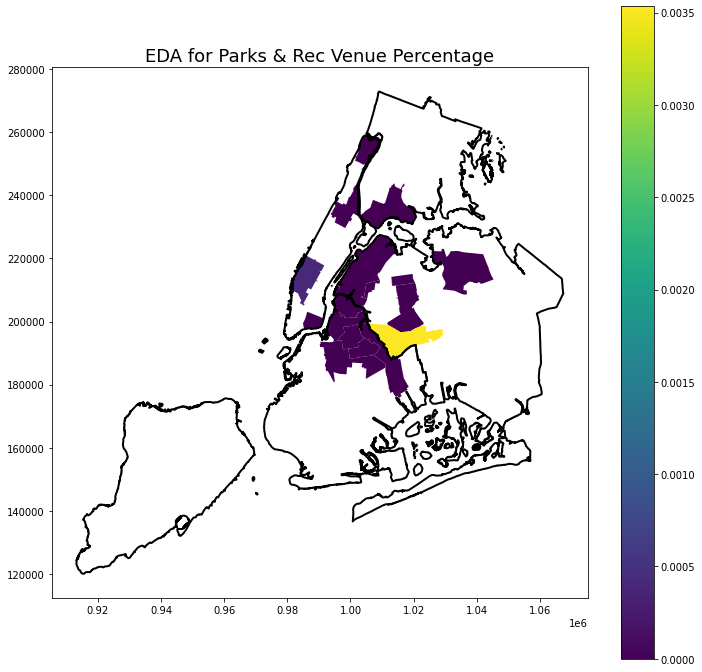

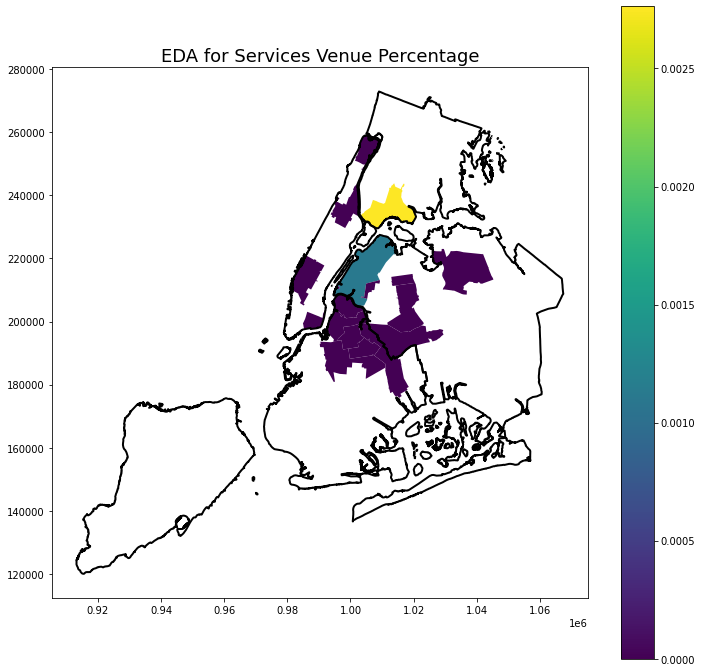

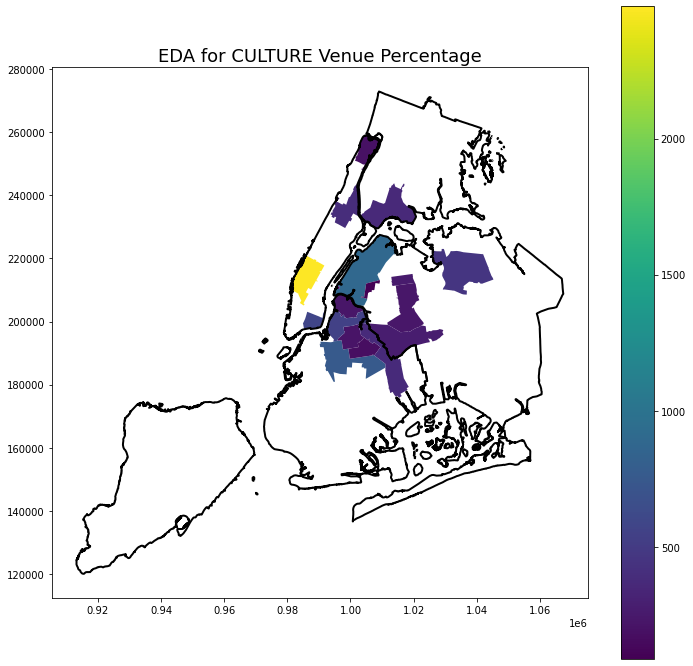

In [28]:
for x in culture_list:
    f, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect('equal')
    ax.set_title("EDA for {} Venue Percentage".format(x), fontsize=18)
    Percentage_Map.plot(axes=ax, column=x, legend = True, cmap='viridis')
    borders.boundary.plot(axes=ax, color=None,edgecolor='k',linewidth = 2)

## Population Normalized

In [29]:
zip_pop = gpd.read_file("ZIP_CODE_040114.shp")

In [30]:
zip_pop['ZIPCODE'] = zip_pop['ZIPCODE'].astype(int)

In [31]:
zip_pop['Neighborhood']= zip_pop['ZIPCODE'].map(zip_dict)

In [32]:
zip_pop.Neighborhood.unique()

array([nan, 'Inwood', 'Harlem', 'South Bronx', 'Astoria/LIC', 'Flushing',
       'Chelsea', 'LIC', 'Greenpoint', 'LES', 'Bushwick', 'Ridgewood',
       'Williamsburg/Bushwick/Bed-Stuy', 'Bed-Stuy', 'Jackson Heights',
       'Elmhurst', 'Bed-Stuy/Bushwick', 'Williamsburg'], dtype=object)

In [33]:
zip_pop = zip_pop[zip_pop['Neighborhood'].notna()]
len(zip_pop)

43

In [ ]:
zip_pop.columns

In [34]:
df3 = zip_pop.pivot_table(values='POPULATION', columns=['Neighborhood'], aggfunc='sum')

In [35]:
df3 = df3.T

In [36]:
df3 = df3.reset_index()

In [37]:
df3.columns

Index(['Neighborhood', 'POPULATION'], dtype='object')

In [38]:
df3.head()
#df3.to_csv('ZipCodePopulation.csv', index = False, header=True)

Neighborhood  POPULATION
0        Astoria/LIC    174003.0
1           Bed-Stuy    208388.0
2  Bed-Stuy/Bushwick     80232.0
3           Bushwick    142891.0
4            Chelsea    144019.0

In [39]:
XYZ_map.head()

Neighborho  \
0                     Astoria/LIC   
1                        Bed-Stuy   
2               Bed-Stuy/Bushwick   
3  Bed-Stuy/Bushwick/Williamsburg   
4                        Bushwick   

                                            geometry  \
0  POLYGON ((1009325.441963157 227420.494683804, ...   
1  POLYGON ((997184.5413762229 194069.7142726228,...   
2  POLYGON ((1001383.64485465 188443.122179389, 1...   
3  POLYGON ((1002987.943483308 197218.0475428849,...   
4  POLYGON ((1005006.704865714 199410.7685511135,...   

                     Neighborhood  Arts & Culture  Body  Drinks  \
0                     Astoria/LIC              21     1     141   
1                        Bed-Stuy              27     1      97   
2               Bed-Stuy/Bushwick               9     0      17   
3  Williamsburg/Bushwick/Bed-Stuy              17     0      26   
4                        Bushwick               9     0      42   

   Entertainment  Essentials  Fashion  Fitness  Food  Groups  Home & Hobby  \
0             17          38        0        1   617      16             2   
1              6          90        1        0   504      27             1   
2              2          24        1        1   115       5             0   
3              4          25        2        0   130      11             0   
4              4          21        0        0   282       8             1   

   Lodging  Misc  Parks & Rec  Services  CULTURE  
0       38     0            0         1      893  
1        9     0            0         0      763  
2        3     0            0         0      177  
3        5     0            0         0      220  
4        3     2            0         0      372

In [40]:
PopulationMap = XYZ_map.merge(df3, on='Neighborhood')

In [41]:
PopulationMap.head()

Neighborho  \
0                     Astoria/LIC   
1                        Bed-Stuy   
2               Bed-Stuy/Bushwick   
3  Bed-Stuy/Bushwick/Williamsburg   
4                        Bushwick   

                                            geometry  \
0  POLYGON ((1009325.441963157 227420.494683804, ...   
1  POLYGON ((997184.5413762229 194069.7142726228,...   
2  POLYGON ((1001383.64485465 188443.122179389, 1...   
3  POLYGON ((1002987.943483308 197218.0475428849,...   
4  POLYGON ((1005006.704865714 199410.7685511135,...   

                     Neighborhood  Arts & Culture  Body  Drinks  \
0                     Astoria/LIC              21     1     141   
1                        Bed-Stuy              27     1      97   
2               Bed-Stuy/Bushwick               9     0      17   
3  Williamsburg/Bushwick/Bed-Stuy              17     0      26   
4                        Bushwick               9     0      42   

   Entertainment  Essentials  Fashion  Fitness  Food  Groups  Home & Hobby  \
0             17          38        0        1   617      16             2   
1              6          90        1        0   504      27             1   
2              2          24        1        1   115       5             0   
3              4          25        2        0   130      11             0   
4              4          21        0        0   282       8             1   

   Lodging  Misc  Parks & Rec  Services  CULTURE  POPULATION  
0       38     0            0         1      893    174003.0  
1        9     0            0         0      763    208388.0  
2        3     0            0         0      177     80232.0  
3        5     0            0         0      220     83575.0  
4        3     2            0         0      372    142891.0

In [42]:
PopulationMap[culture_list] = PopulationMap[culture_list].div(PopulationMap['POPULATION'], axis=0)
PopulationMap.head()

Neighborho  \
0                     Astoria/LIC   
1                        Bed-Stuy   
2               Bed-Stuy/Bushwick   
3  Bed-Stuy/Bushwick/Williamsburg   
4                        Bushwick   

                                            geometry  \
0  POLYGON ((1009325.441963157 227420.494683804, ...   
1  POLYGON ((997184.5413762229 194069.7142726228,...   
2  POLYGON ((1001383.64485465 188443.122179389, 1...   
3  POLYGON ((1002987.943483308 197218.0475428849,...   
4  POLYGON ((1005006.704865714 199410.7685511135,...   

                     Neighborhood  Arts & Culture      Body    Drinks  \
0                     Astoria/LIC        0.000121  0.000006  0.000810   
1                        Bed-Stuy        0.000130  0.000005  0.000465   
2               Bed-Stuy/Bushwick        0.000112  0.000000  0.000212   
3  Williamsburg/Bushwick/Bed-Stuy        0.000203  0.000000  0.000311   
4                        Bushwick        0.000063  0.000000  0.000294   

   Entertainment  Essentials   Fashion   Fitness      Food    Groups  \
0       0.000098    0.000218  0.000000  0.000006  0.003546  0.000092   
1       0.000029    0.000432  0.000005  0.000000  0.002419  0.000130   
2       0.000025    0.000299  0.000012  0.000012  0.001433  0.000062   
3       0.000048    0.000299  0.000024  0.000000  0.001555  0.000132   
4       0.000028    0.000147  0.000000  0.000000  0.001974  0.000056   

   Home & Hobby   Lodging      Misc  Parks & Rec  Services   CULTURE  \
0      0.000011  0.000218  0.000000          0.0  0.000006  0.005132   
1      0.000005  0.000043  0.000000          0.0  0.000000  0.003661   
2      0.000000  0.000037  0.000000          0.0  0.000000  0.002206   
3      0.000000  0.000060  0.000000          0.0  0.000000  0.002632   
4      0.000007  0.000021  0.000014          0.0  0.000000  0.002603   

   POPULATION  
0    174003.0  
1    208388.0  
2     80232.0  
3     83575.0  
4    142891.0

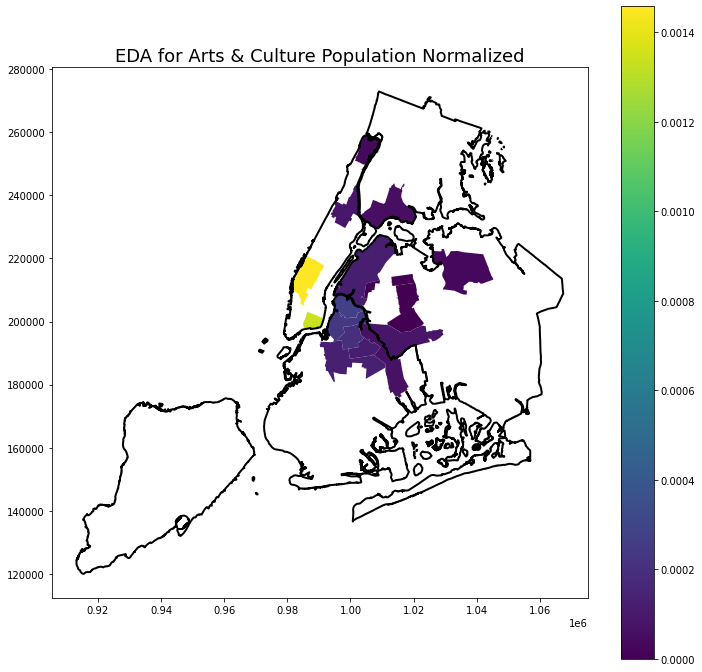

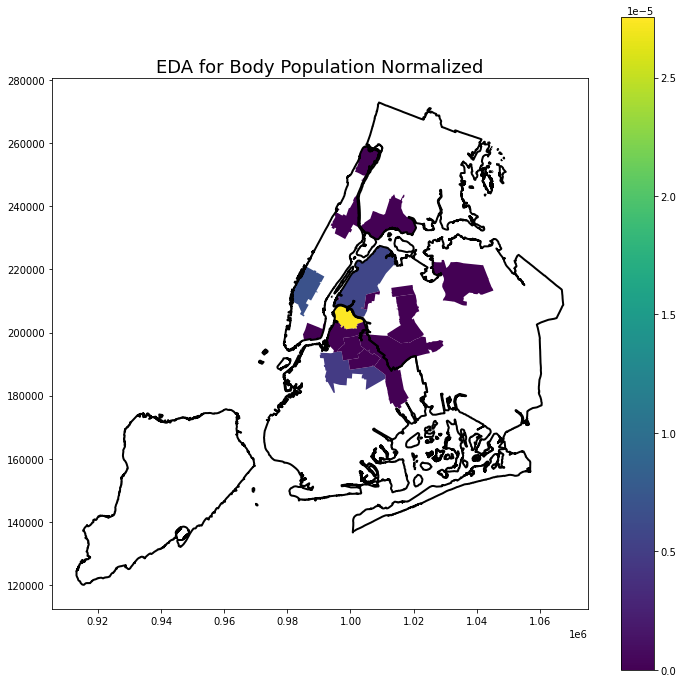

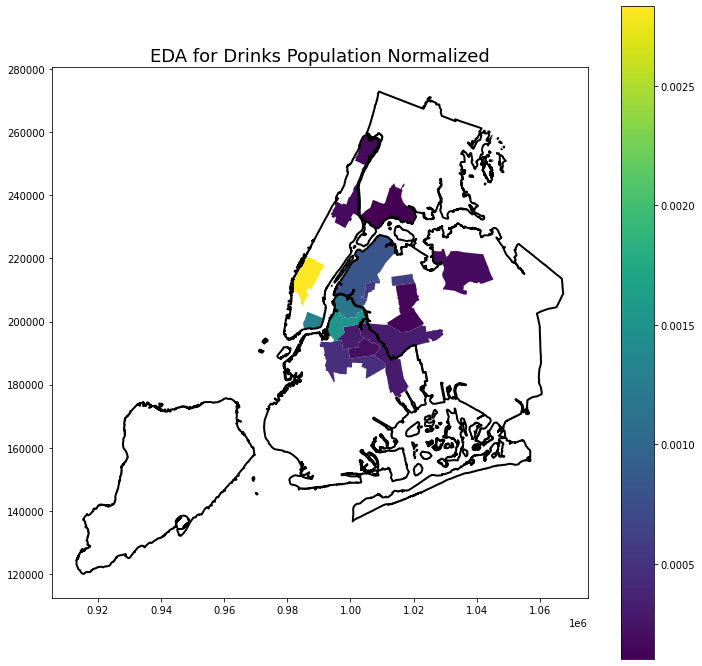

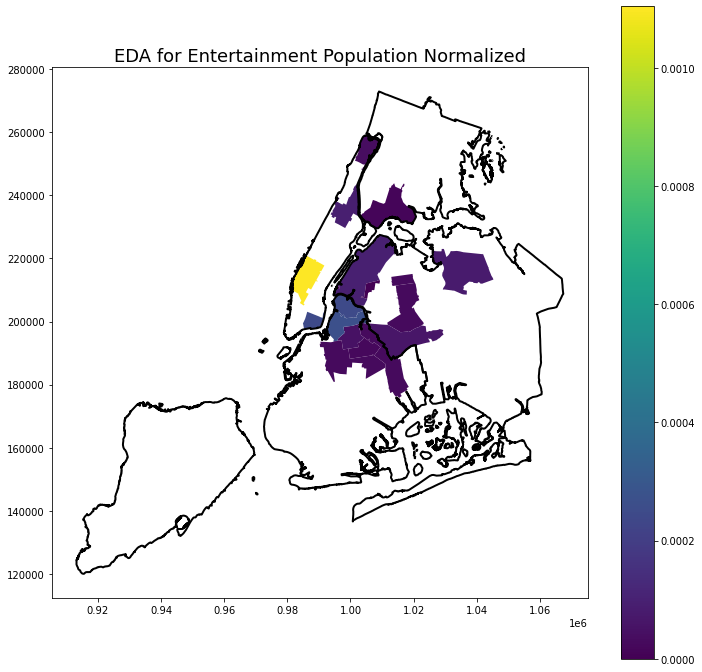

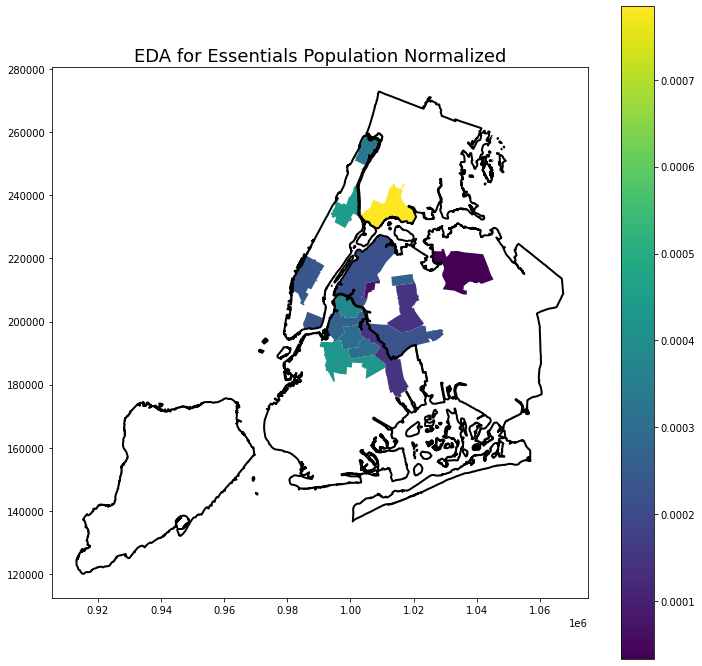

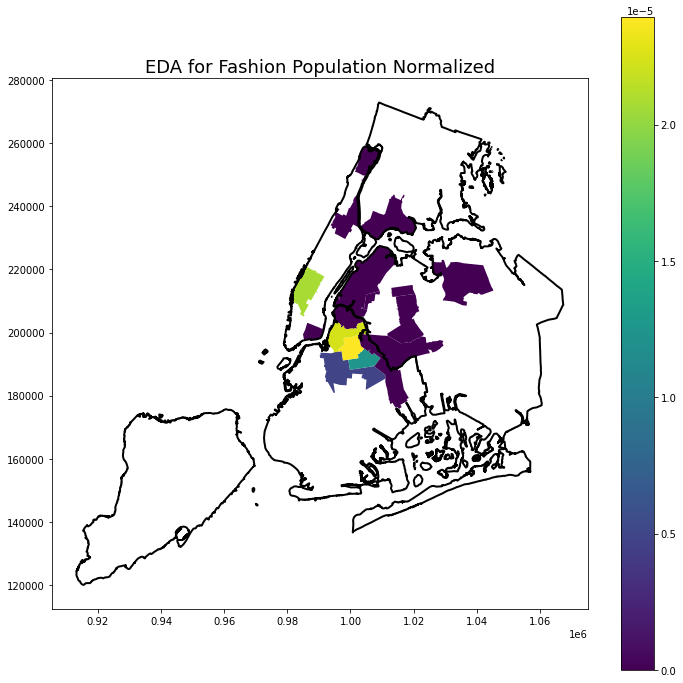

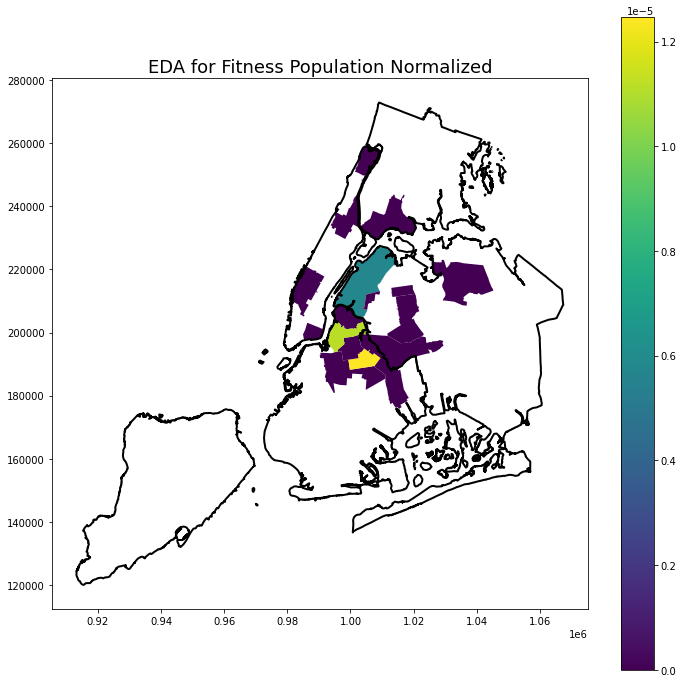

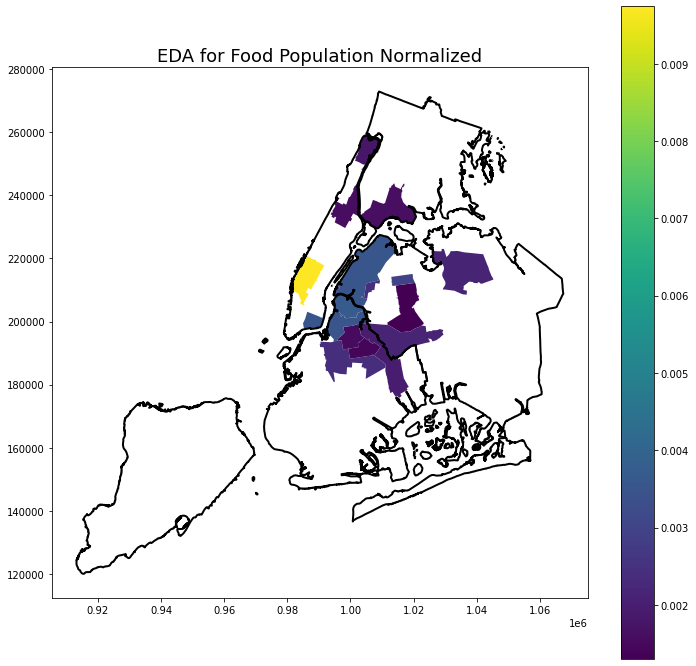

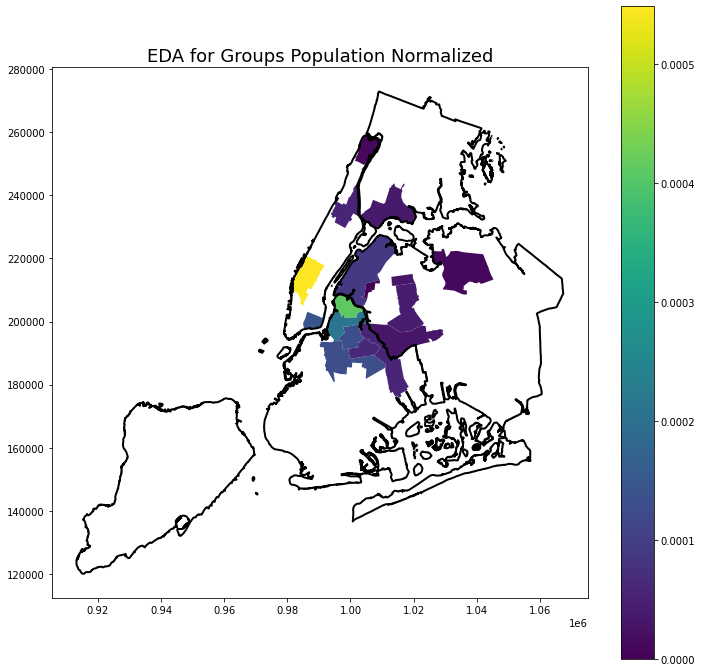

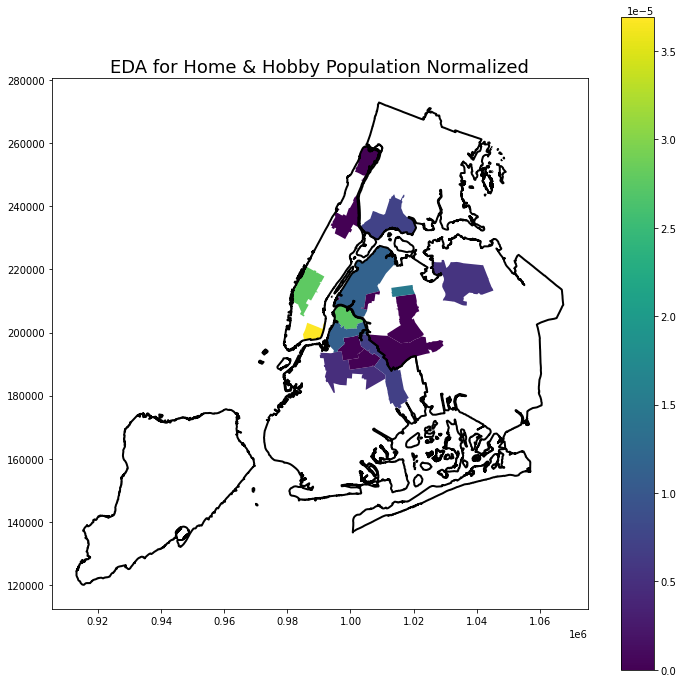

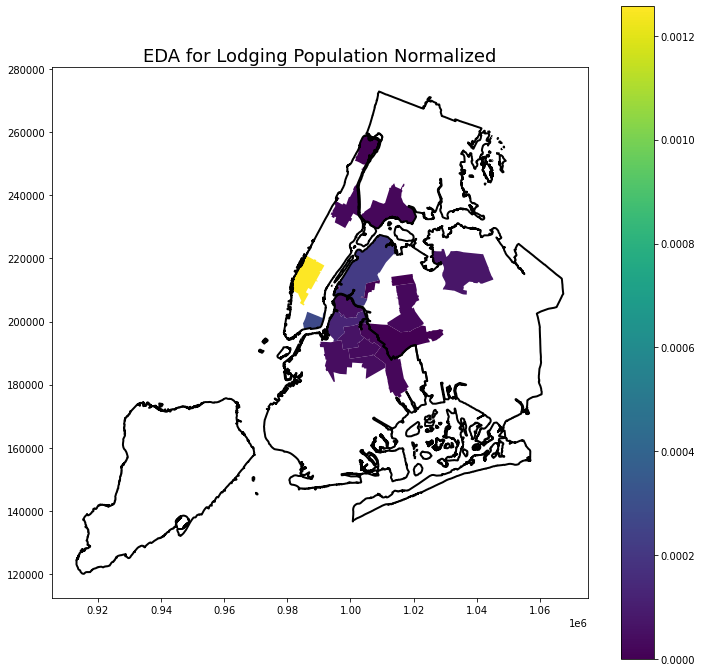

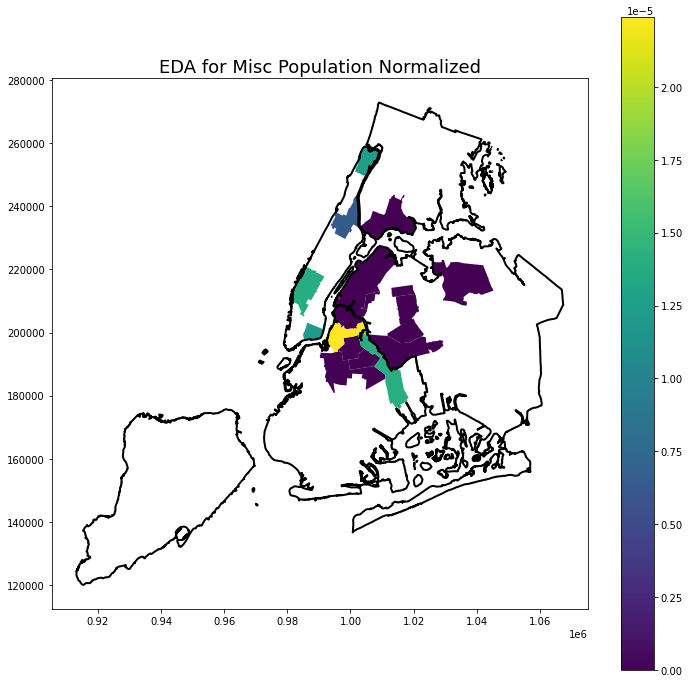

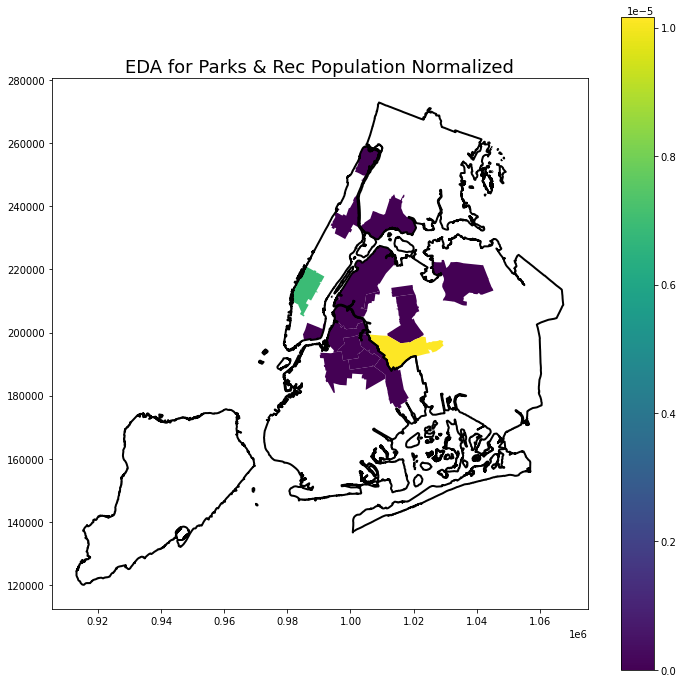

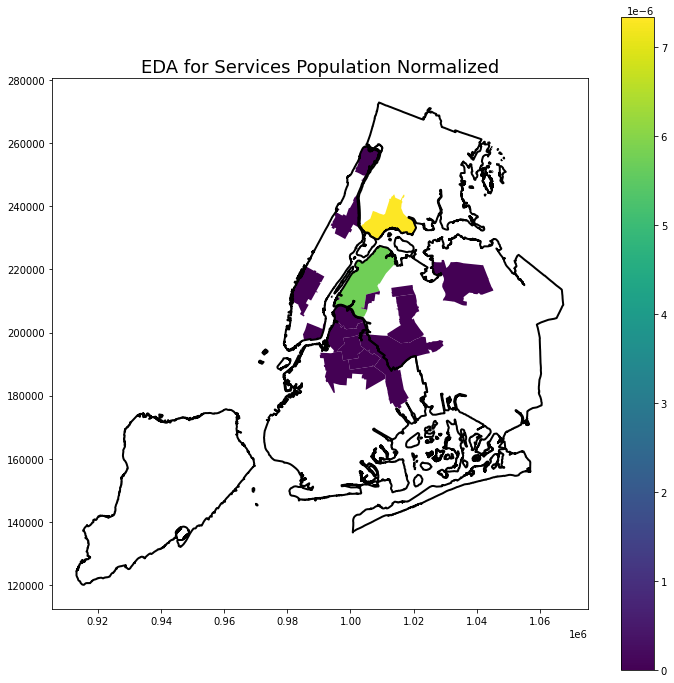

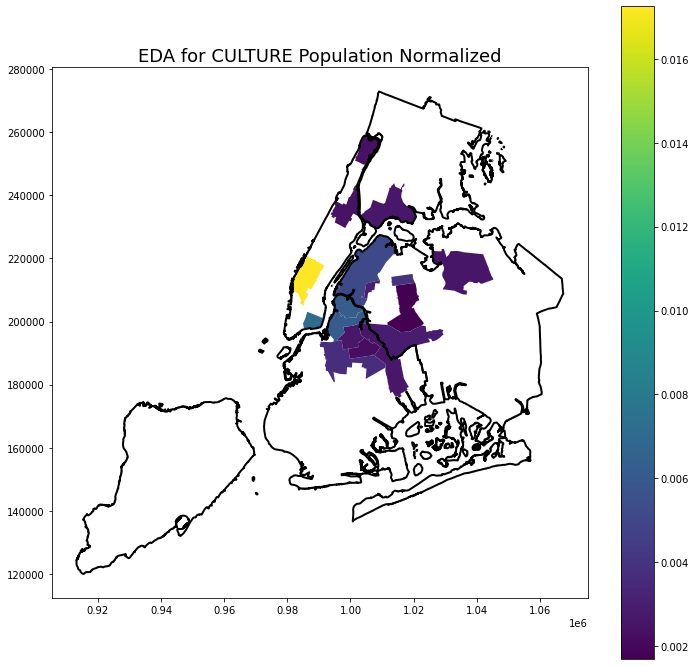

In [43]:
for x in culture_list:
    f, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect('equal')
    ax.set_title("EDA for {} Population Normalized".format(x), fontsize=18)
    PopulationMap.plot(axes=ax, column=x, legend = True, cmap='viridis')
    borders.boundary.plot(axes=ax, color=None,edgecolor='k',linewidth = 2)

## Unpivoted Table -- Viv's Request

In [ ]:
# LiveXYZ.columns

In [ ]:
# Unpivoted = LiveXYZ[['name', 'address', 'ZIPCODE', 'latitude', 'longitude', 'primary_category.0_name','primary_category.1_name']]
# Unpivoted = Unpivoted[Unpivoted['ZIPCODE'].isin(pertinent_zips)]
# Unpivoted['Neighborhood']= Unpivoted['ZIPCODE'].map(zip_dict)
# Unpivoted.to_csv('Unpivoted.csv', index = False, header=True)

## Venues per Pop DataFrame

In [47]:
# dataframe = PopulationMap[['Neighborhood', 'CULTURE', 'POPULATION']]
# dataframe['CULTURE'] = dataframe['CULTURE'] * dataframe['POPULATION']
# dataframe
# dataframe.to_csv('ZipCodePopulation.csv', index = False, header=True)

C:\Users\aniha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
